In [2]:
import numpy as np
import os
import utils.load_data 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

path = "data1/2、不同浓度下甲醛和乙醇"
data_dict = utils.load_data.read_data(path)

class_num = len(list(data_dict.keys()))                
for key, value in data_dict.items():
    print(key, )


自动检测出时间序列，已删除,data1/2、不同浓度下甲醛和乙醇\0.1 ppm乙醇/30%RH C2H6O 0.1.txt ----> data1/2、不同浓度下甲醛和乙醇\0.1 ppm乙醇 (5249, 5)
自动检测出时间序列，已删除,data1/2、不同浓度下甲醛和乙醇\0.1 ppm乙醇/40%RH C2H6O 0.1.txt ----> data1/2、不同浓度下甲醛和乙醇\0.1 ppm乙醇 (5250, 5)
自动检测出时间序列，已删除,data1/2、不同浓度下甲醛和乙醇\0.1 ppm乙醇/50%RH C2H6O 0.1.txt ----> data1/2、不同浓度下甲醛和乙醇\0.1 ppm乙醇 (5250, 5)
自动检测出时间序列，已删除,data1/2、不同浓度下甲醛和乙醇\0.1 ppm乙醇/60%RH C2H6O 0.1.txt ----> data1/2、不同浓度下甲醛和乙醇\0.1 ppm乙醇 (5250, 5)
自动检测出时间序列，已删除,data1/2、不同浓度下甲醛和乙醇\0.1 ppm乙醇/70%RH C2H6O 0.1.txt ----> data1/2、不同浓度下甲醛和乙醇\0.1 ppm乙醇 (5250, 5)
自动检测出时间序列，已删除,data1/2、不同浓度下甲醛和乙醇\0.1 ppm甲醛/30%RH HCHO 0.1.txt ----> data1/2、不同浓度下甲醛和乙醇\0.1 ppm甲醛 (5250, 5)
自动检测出时间序列，已删除,data1/2、不同浓度下甲醛和乙醇\0.1 ppm甲醛/40%RH HCHO 0.1.txt ----> data1/2、不同浓度下甲醛和乙醇\0.1 ppm甲醛 (5250, 5)
自动检测出时间序列，已删除,data1/2、不同浓度下甲醛和乙醇\0.1 ppm甲醛/50%RH HCHO 0.1.txt ----> data1/2、不同浓度下甲醛和乙醇\0.1 ppm甲醛 (5250, 5)
自动检测出时间序列，已删除,data1/2、不同浓度下甲醛和乙醇\0.1 ppm甲醛/60%RH HCHO 0.1.txt ----> data1/2、不同浓度下甲醛和乙醇\0.1 ppm甲醛 (5250, 5)
自动检测出时间序列，已删除,data1/2、不同浓度下甲醛和乙醇

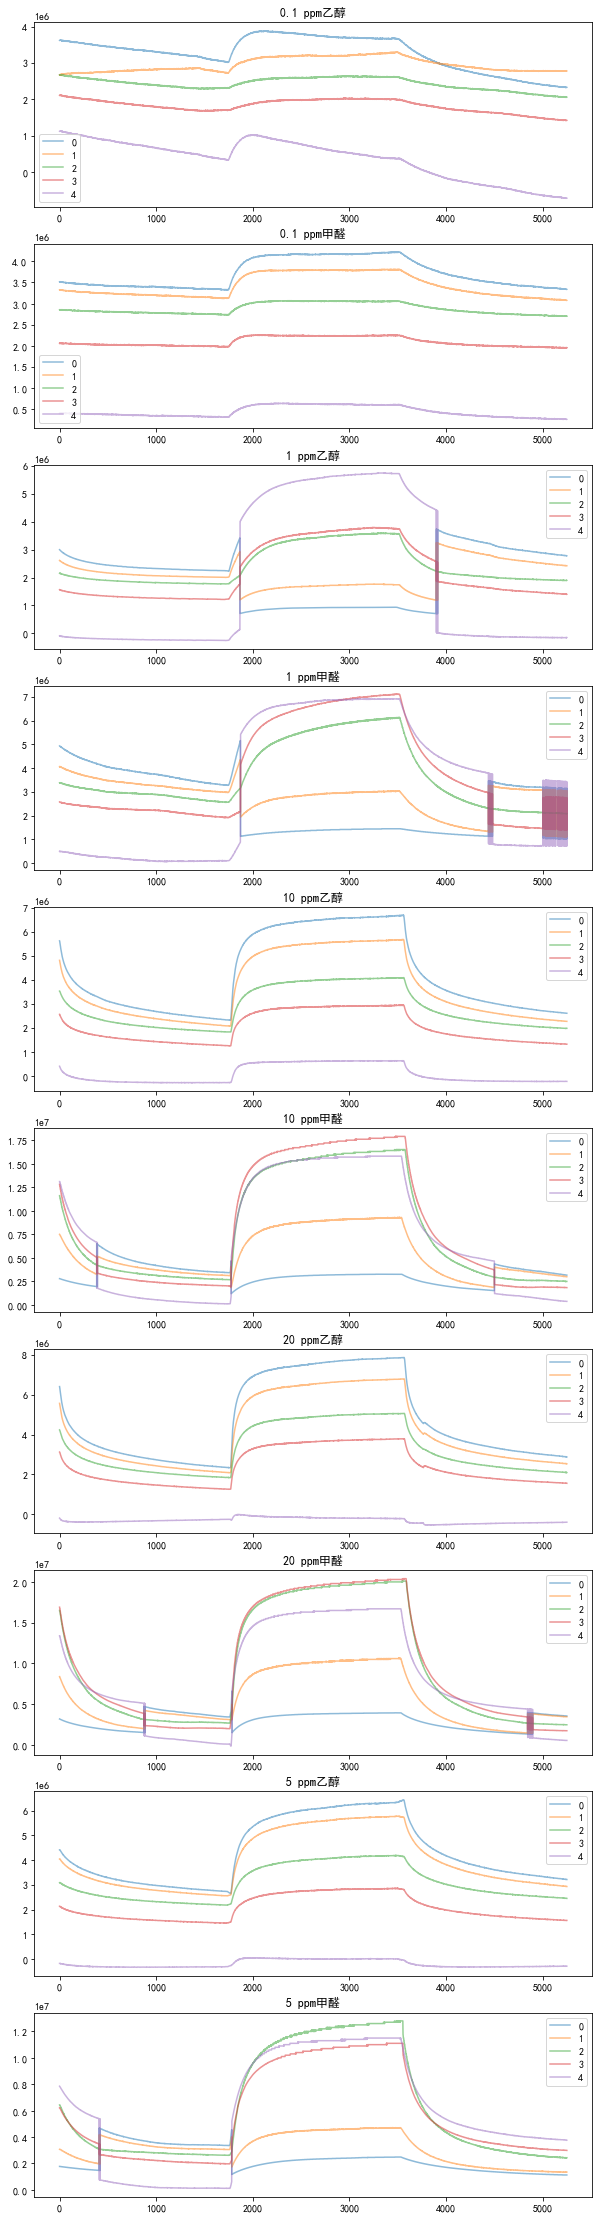

In [3]:

# scaler = StandardScaler()
plt.figure(figsize=[10,40])
for i ,key in enumerate(list(data_dict.keys())):
    ax = plt.subplot2grid((class_num,1), (i,0))
    data_num = len(list(data_dict[key]))
    data_show = data_dict[key][np.random.randint(0,data_num)]
    # data_show = scaler.fit_transform(data_show)
    for j in range(data_show.shape[1]): 
        ax.plot(range(data_show.shape[0]),data_show[:,j],label = j,alpha = 0.5)
    ax.set_title(key)
    ax.legend()
plt.show()

# 用roc aur那一套判断lda分类准确率
由于样本较少，将随机抽一个样本做为测试集，全部随机一遍过后做平均

In [8]:
import utils.feature 

data_feature_dict = {}
for i in data_dict.items():
    featured_data_list = []
    for j in i[1]:
        feature_data = utils.feature.get_all_feature(j)
        featured_data_list.append(feature_data)
    data_feature_dict[i[0]]=featured_data_list